In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.linear_model  import LinearRegression ,  Ridge, Lasso
from sklearn.neighbors  import KNeighborsRegressor
from sklearn.tree  import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor , GradientBoostingRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('DataSet\Exam_Score_Prediction.csv')
df.head()

,student_id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
0,1,17,male,diploma,2.78,92.9,yes,7.4,poor,coaching,low,hard,58.9
1,2,23,other,bca,3.37,64.8,yes,4.6,average,online videos,medium,moderate,54.8
2,3,22,male,b.sc,7.88,76.8,yes,8.5,poor,coaching,high,moderate,90.3
3,4,20,other,diploma,0.67,48.4,yes,5.8,average,online videos,low,moderate,29.7
4,5,20,female,diploma,0.89,71.6,yes,9.8,poor,coaching,low,moderate,43.7


In [3]:
target = 'exam_score'
df = df.drop(columns=['student_id'])
categorical_cols = ['gender','course','internet_access','sleep_quality','study_method','facility_rating','exam_difficulty']

numerical_cols = [col for col in df.columns if col not in categorical_cols + [target]]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               20000 non-null  int64  
 1   gender            20000 non-null  object 
 2   course            20000 non-null  object 
 3   study_hours       20000 non-null  float64
 4   class_attendance  20000 non-null  float64
 5   internet_access   20000 non-null  object 
 6   sleep_hours       20000 non-null  float64
 7   sleep_quality     20000 non-null  object 
 8   study_method      20000 non-null  object 
 9   facility_rating   20000 non-null  object 
 10  exam_difficulty   20000 non-null  object 
 11  exam_score        20000 non-null  float64
dtypes: float64(4), int64(1), object(7)
memory usage: 1.8+ MB


In [5]:
df.shape

(20000, 12)

In [6]:
df.describe()

,age,study_hours,class_attendance,sleep_hours,exam_score
count,20000.000000,20000.000000,20000.000000,20000.00000,20000.000000
mean,20.473300,4.007604,70.017365,7.00856,62.513225
std,2.284458,2.308313,17.282262,1.73209,18.908491
min,17.000000,0.080000,40.600000,4.10000,19.599000
25%,18.000000,2.000000,55.100000,5.50000,48.800000
50%,20.000000,4.040000,69.900000,7.00000,62.600000
75%,22.000000,6.000000,85.000000,8.50000,76.300000
max,24.000000,7.910000,99.400000,9.90000,100.000000


In [7]:
df.isnull().sum()

age                 0
gender              0
course              0
study_hours         0
class_attendance    0
internet_access     0
sleep_hours         0
sleep_quality       0
study_method        0
facility_rating     0
exam_difficulty     0
exam_score          0
dtype: int64

In [8]:
df.duplicated().sum()

np.int64(0)

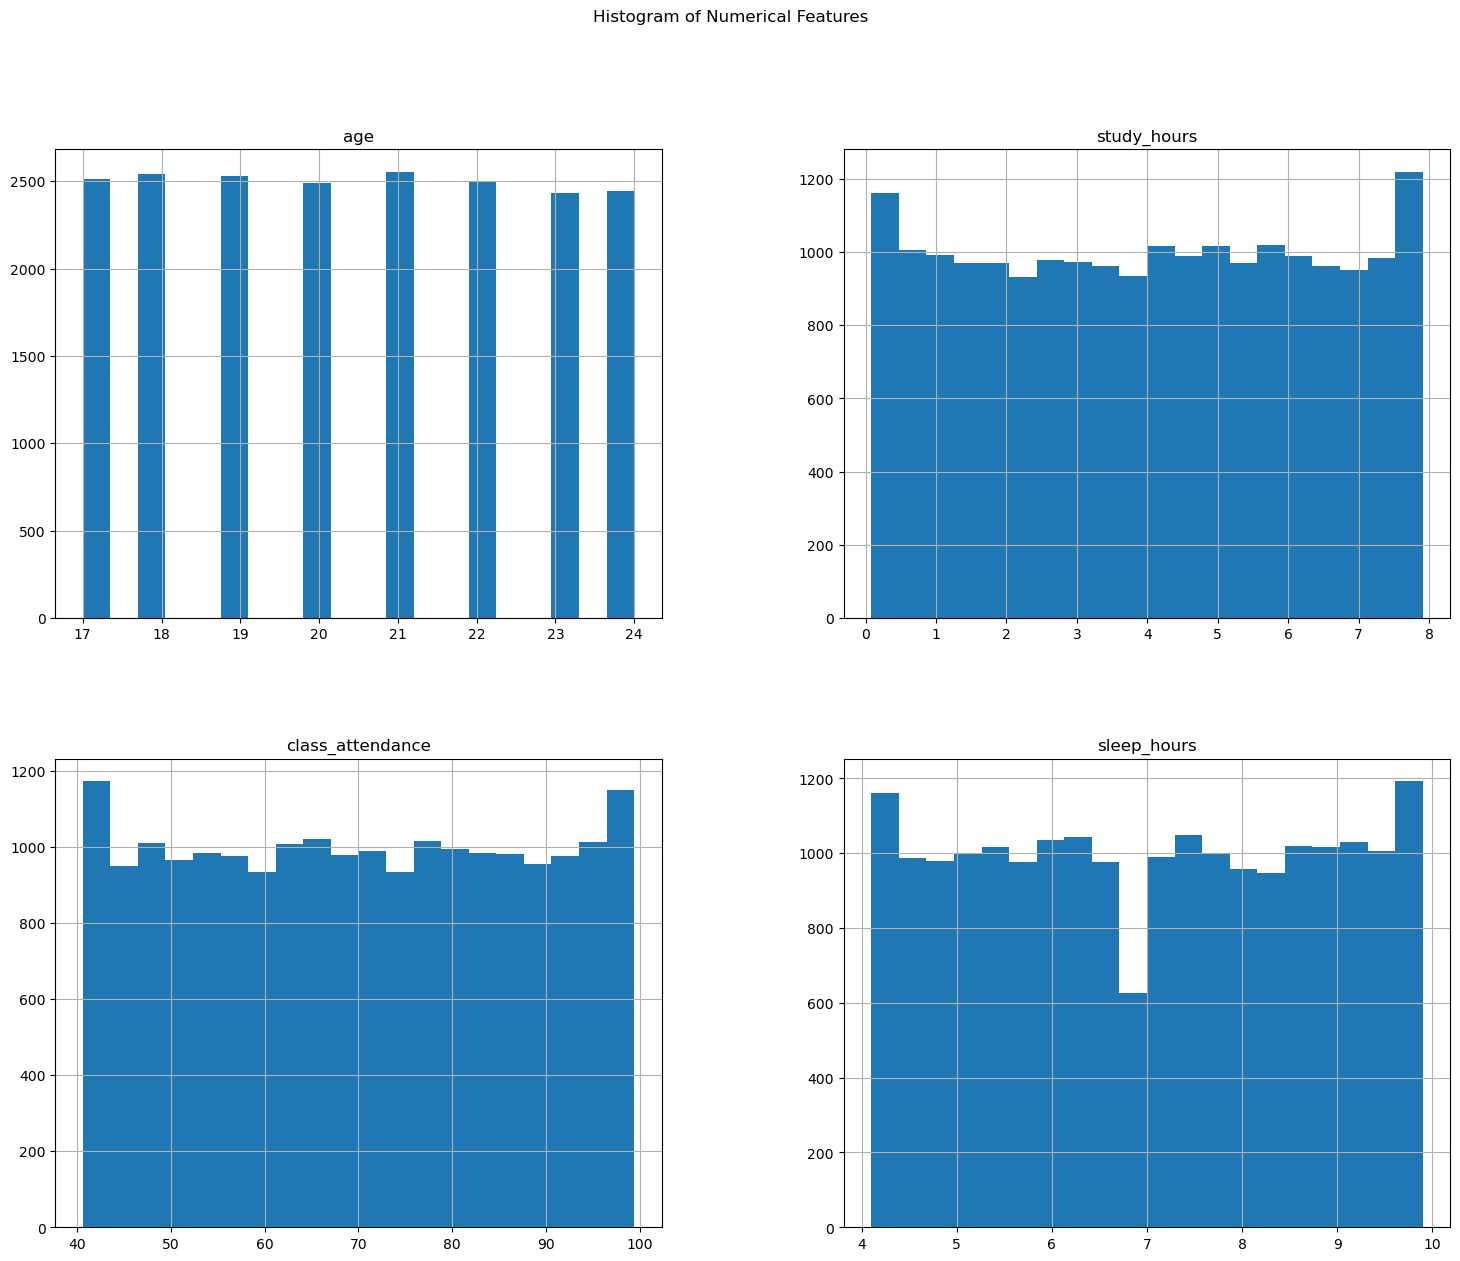

In [9]:
df[numerical_cols].hist(figsize=(18,14),bins=20)
plt.suptitle("Histogram of Numerical Features")
plt.show()

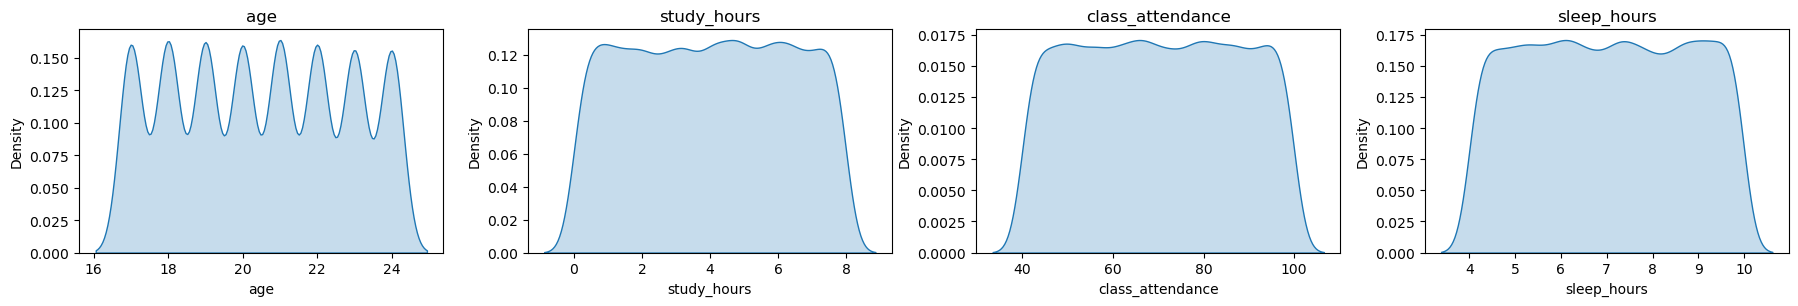

In [10]:
plt.figure(figsize=(18,14))

for i, col in enumerate(numerical_cols):
  plt.subplot(5,4,i+1)
  sns.kdeplot(df[col],fill=True)
  plt.title(col)
plt.tight_layout()
plt.show()

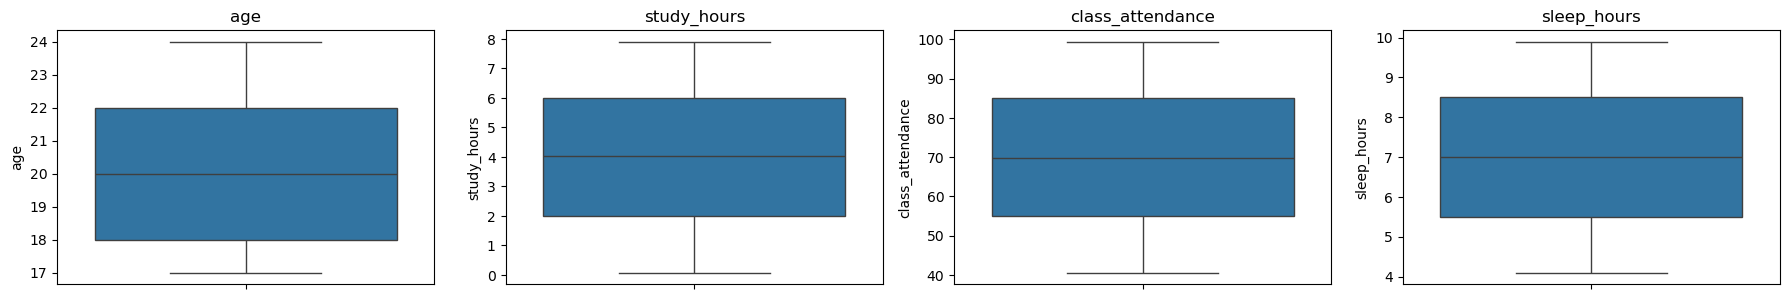

In [11]:
plt.figure(figsize=(18,14))

for i, col in enumerate(numerical_cols):
  plt.subplot(5,4,i+1)
  sns.boxplot(df[col],fill=True)
  plt.title(col)
plt.tight_layout()
plt.show()

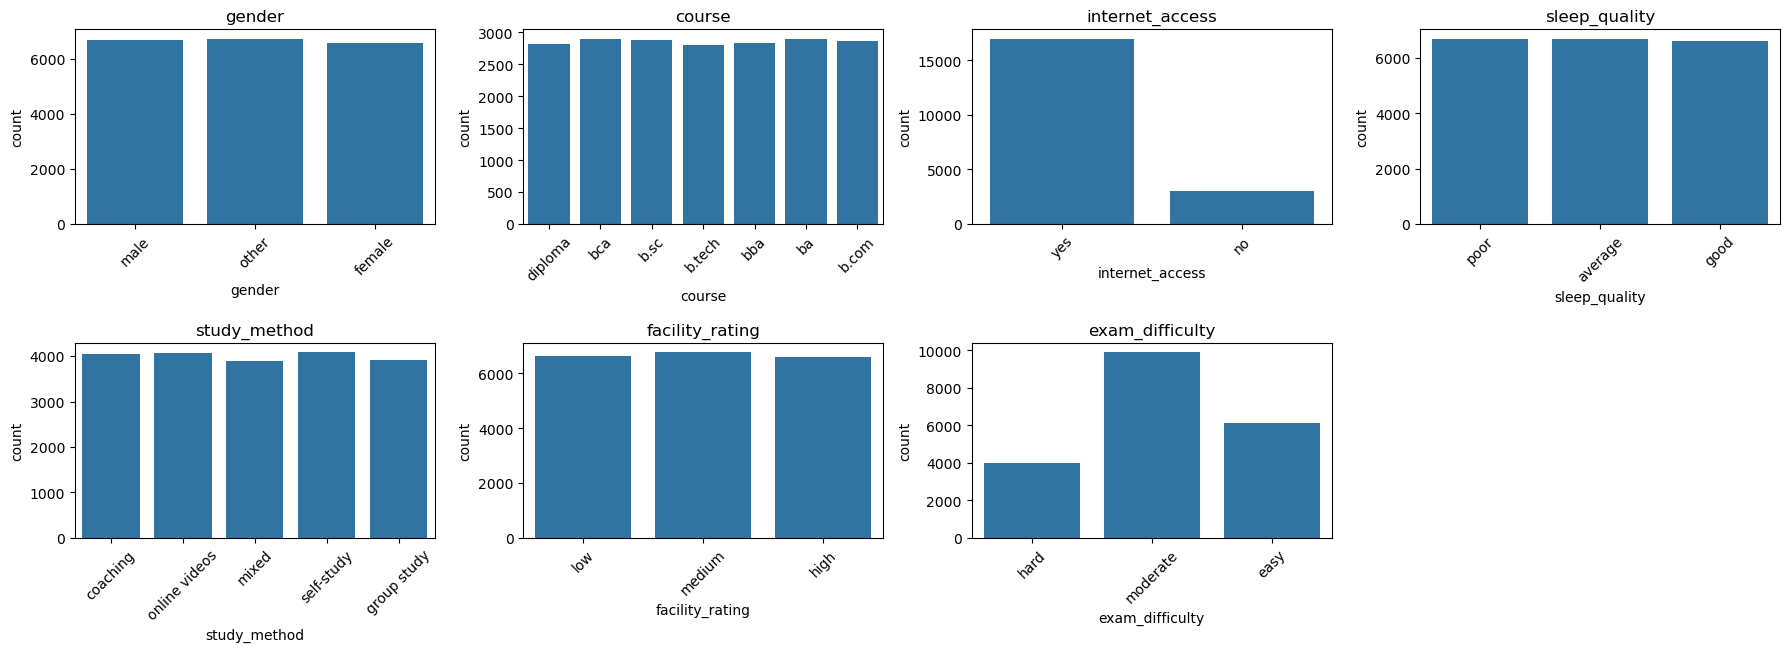

In [12]:
plt.figure(figsize=(18,15))
for i, col in enumerate(categorical_cols):
    plt.subplot(5,4,i+1)
    sns.countplot(x=df[col])
    plt.xticks(rotation=45)
    plt.title(col)
plt.tight_layout()
plt.show()


<Axes: >

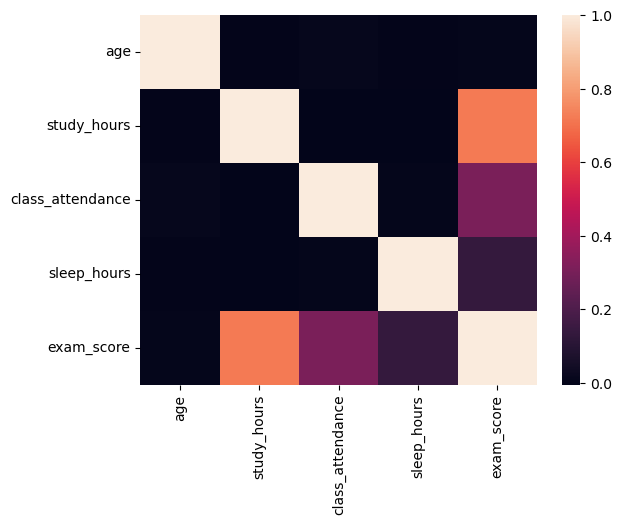

In [13]:
sns.heatmap(df.corr(numeric_only = True))

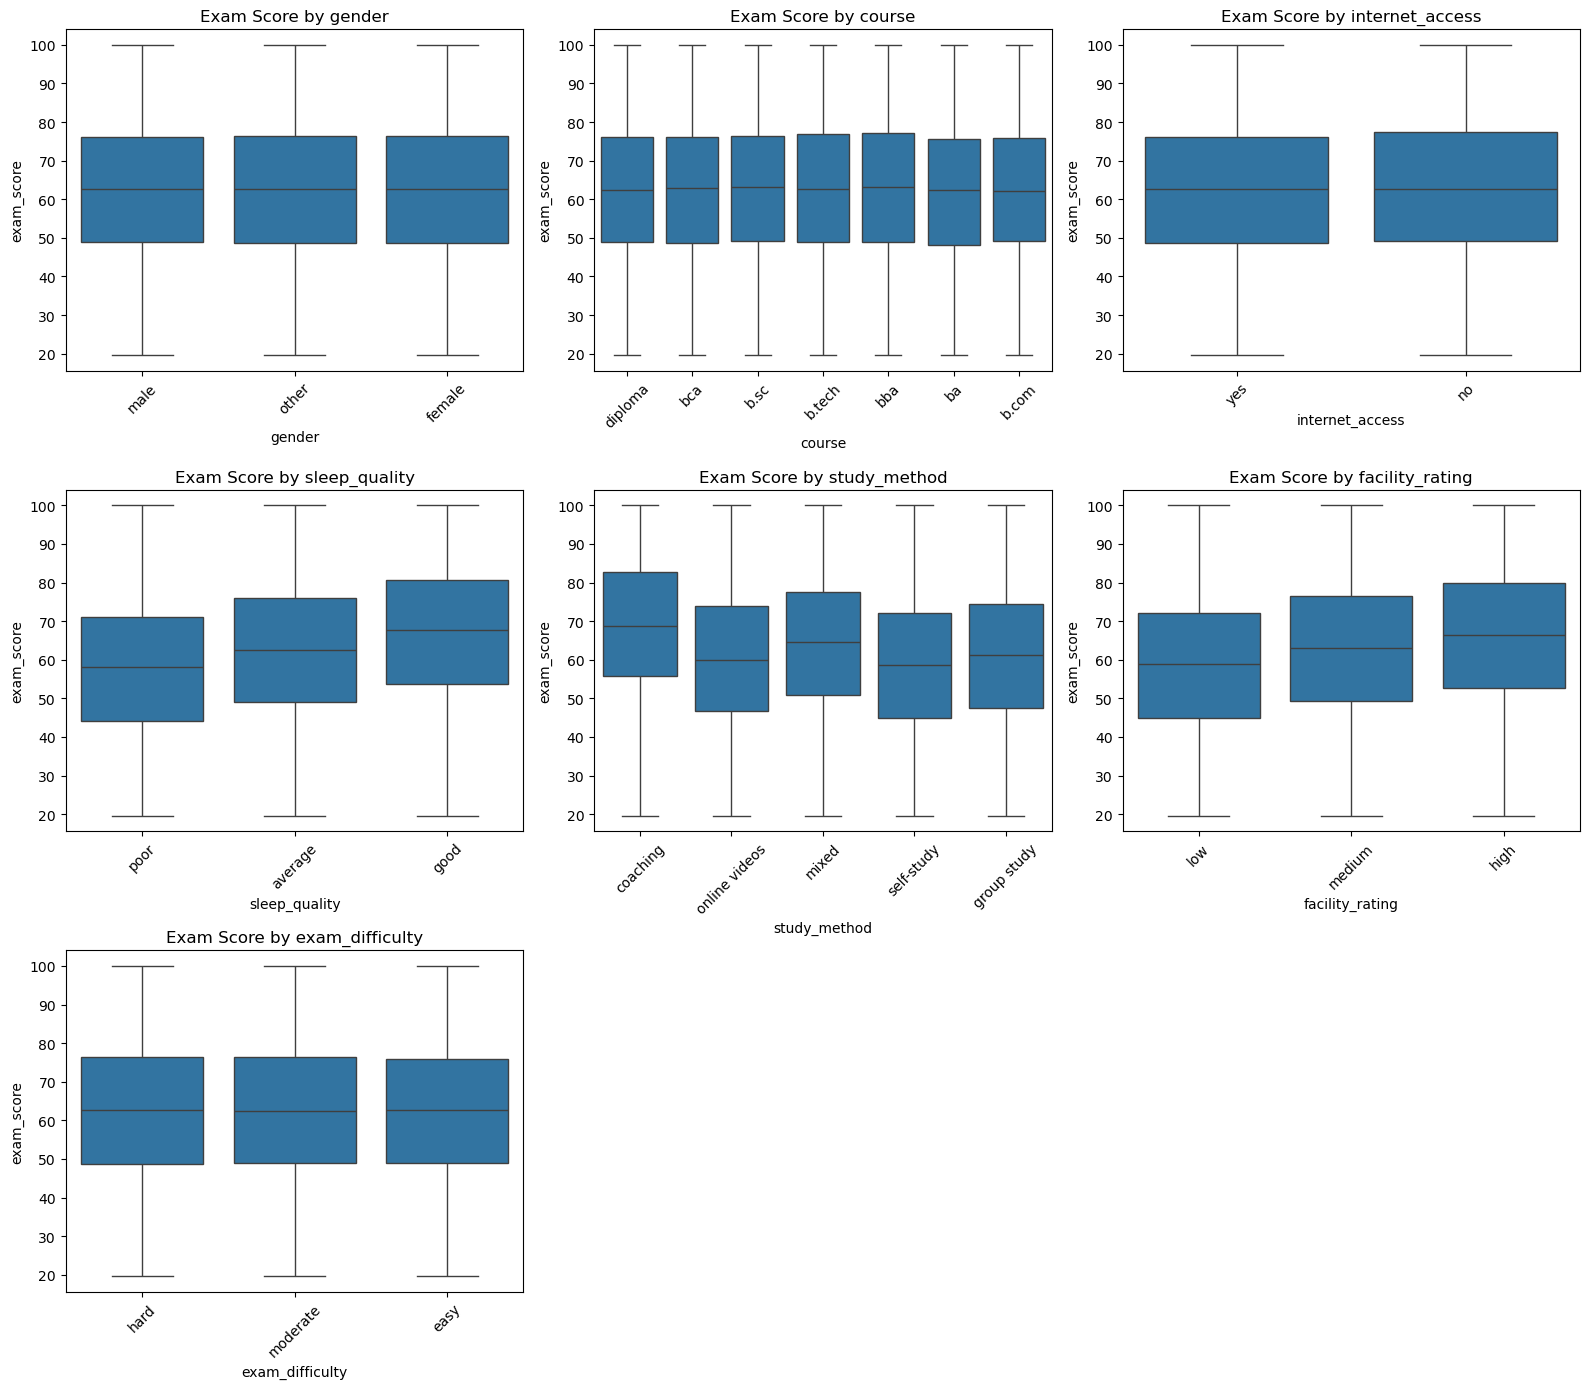

In [14]:
cat_cols = ['gender', 'course', 'internet_access', 'sleep_quality', 
            'study_method', 'facility_rating', 'exam_difficulty']

fig, axes = plt.subplots(3, 3, figsize=(16, 14))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    sns.boxplot(data=df, x=col, y='exam_score', ax=axes[i])
    axes[i].set_title(f'Exam Score by {col}', fontsize=12)
    axes[i].tick_params(axis='x', rotation=45)

# Hide empty subplots
for j in range(len(cat_cols), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

## Key Insights & Conclusions

### Main Findings:
1. **Study Hours** is the strongest predictor (r=0.762)
2. **Class Attendance** shows moderate correlation (r=0.361)
3. **Sleep Quality**: Good sleep → Higher scores
4. **Study Method**: Coaching shows best results
5. **Facility Rating**: Higher rating → Better performance

### Modeling Suggestions:
- Focus on `study_hours` and `class_attendance` as key features
- Encode categorical variables (sleep_quality, study_method, etc.)
- Consider feature engineering combining study hours with attendance

---

In [15]:
from sklearn.preprocessing import OrdinalEncoder
df = pd.get_dummies(df, columns=['gender','course','study_method'], drop_first=True)
df['internet_access'] = df['internet_access'].map({'no': 0, 'yes': 1})
encoder = OrdinalEncoder(
    handle_unknown='use_encoded_value',
    unknown_value=-1
)
df['sleep_quality'] = encoder.fit_transform(df[['sleep_quality']])
df['facility_rating'] = encoder.fit_transform(df[['facility_rating']])
df['exam_difficulty'] = encoder.fit_transform(df[['exam_difficulty']])

In [16]:

df.head()

,age,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,facility_rating,exam_difficulty,exam_score,gender_male,...,course_b.sc,course_b.tech,course_ba,course_bba,course_bca,course_diploma,study_method_group study,study_method_mixed,study_method_online videos,study_method_self-study
0,17,2.78,92.9,1,7.4,2.0,1.0,1.0,58.9,True,...,False,False,False,False,False,True,False,False,False,False
1,23,3.37,64.8,1,4.6,0.0,2.0,2.0,54.8,False,...,False,False,False,False,True,False,False,False,True,False
2,22,7.88,76.8,1,8.5,2.0,0.0,2.0,90.3,True,...,True,False,False,False,False,False,False,False,False,False
3,20,0.67,48.4,1,5.8,0.0,1.0,2.0,29.7,False,...,False,False,False,False,False,True,False,False,True,False
4,20,0.89,71.6,1,9.8,2.0,1.0,2.0,43.7,False,...,False,False,False,False,False,True,False,False,False,False


In [17]:
df.astype('int')

,age,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,facility_rating,exam_difficulty,exam_score,gender_male,...,course_b.sc,course_b.tech,course_ba,course_bba,course_bca,course_diploma,study_method_group study,study_method_mixed,study_method_online videos,study_method_self-study
0,17,2,92,1,7,2,1,1,58,1,...,0,0,0,0,0,1,0,0,0,0
1,23,3,64,1,4,0,2,2,54,0,...,0,0,0,0,1,0,0,0,1,0
2,22,7,76,1,8,2,0,2,90,1,...,1,0,0,0,0,0,0,0,0,0
3,20,0,48,1,5,0,1,2,29,0,...,0,0,0,0,0,1,0,0,1,0
4,20,0,71,1,9,2,1,2,43,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,18,6,71,1,5,1,1,0,86,0,...,0,0,0,1,0,0,0,0,0,1
19996,18,3,41,0,5,0,2,2,60,1,...,0,0,0,0,0,0,0,0,0,0
19997,19,7,68,1,4,2,1,0,64,0,...,0,0,0,0,0,1,1,0,0,0
19998,19,4,76,0,6,1,2,2,79,1,...,0,0,0,1,0,0,0,0,0,1


In [18]:
X = df.drop(columns = (target),axis = 1)
y = df[target]

In [19]:
scaler =  StandardScaler()

X_scaled = scaler.fit_transform(X)

In [20]:
X_train , X_test , y_train , y_test = train_test_split(X_scaled,y,test_size = 0.2, random_state=42)

In [21]:
from xgboost import XGBRegressor
models = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "DecisionTree": DecisionTreeRegressor(),
    "RandomForest": RandomForestRegressor(),
    "GradientBoost": GradientBoostingRegressor(),
    "SVR": SVR(),
    "KNN": KNeighborsRegressor(),
    "XGBoost": XGBRegressor(objective='reg:squarederror')
}

In [22]:
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    r2 = r2_score(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    
    results.append([name, r2, mae, rmse])

results_df = pd.DataFrame(results, columns=['Model','R2','MAE','RMSE'])
results_df.sort_values(by='R2', ascending=False)

,Model,R2,MAE,RMSE
5,GradientBoost,0.725041,8.011046,9.917255
8,XGBoost,0.699019,8.336569,10.375941
6,SVR,0.692539,8.510903,10.487040
4,RandomForest,0.681842,8.624018,10.667900
1,Ridge,0.678162,8.656586,10.729414
0,Linear,0.678162,8.656542,10.729418
2,Lasso,0.642377,9.197349,11.310203
7,KNN,0.505910,10.738980,13.294151
3,DecisionTree,0.345802,12.247069,15.297212


In [24]:
best_model = GradientBoostingRegressor()
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"R2: {r2}, MAE: {mae}, RMSE: {rmse}")
importance = pd.Series(
    best_model.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

print(importance)


R2: 0.725041174230048, MAE: 8.01104647318705, RMSE: 9.917255265517976
study_hours                   0.701650
class_attendance              0.139328
sleep_quality                 0.053553
facility_rating               0.037040
sleep_hours                   0.025117
study_method_group study      0.013726
study_method_online videos    0.013613
study_method_self-study       0.012666
study_method_mixed            0.002897
age                           0.000165
exam_difficulty               0.000090
course_b.tech                 0.000048
gender_male                   0.000044
course_diploma                0.000043
gender_other                  0.000022
internet_access               0.000000
course_b.sc                   0.000000
course_bca                    0.000000
course_ba                     0.000000
course_bba                    0.000000
dtype: float64
